
## Factor Analysis

#### What is factor analysis?

Factor analysis (FA) is the idea of clustering variables of some observed data into a smaller number of so-called factors while still accounting for as much variability as possible. FA does this by exploiting correlations between the variables, assuming that underlying latent variables determine those variables contained in the same factor. It is a method for dimensionality reduction and thus reduces noise, making comparisons between data points easier and thus allowing for applications like facial recognition, anomaly detection, and so on.


#### What are the relationships between covariance matrix, factor analysis, and principal component analysis (PCA)?

PCA is one possible way to perform factor analysis, although they are not exactly the same. When performing PCA on data in feature space, the principal components will be composites of variables which tend to be correlated, hence telling you which variables could be put into the same cluster.

One way to perform PCA in by calculating the covariance matrix of your data and then its eigendecomposition: the eigenvectors will be the PCs while the eigenvalues are the variance along the PCs. This makes intuitive sense, too: since you are trying to capture the most variability in the data in as little dimensions as possible, taking the directions with most explained variance first seems to be a sound method.


#### What do we mean with loadings?

The loading of a variable for a certain factor is the weight of that variable in that factor. When comparing PCA to factor analysis, the loading of variable i for factor j would correspond to the i-th entry of the j-th eigenvector.


#### Why factors are orthogonal to each other? What’s the consequence?

In PCA, the PCs are orthogonal to each other because that is a constraint we set for PCA. Mathematically, they are orthogonal because the eigenvectors of a symmetric matrix (a covariance matrix is always symmetric since $Cov(x,y) = Cov(y,x)$) are orthogonal to each other. In FA, generally, I believe factors are not required to be orthogonal (or at least the Wikipedia article does not say so).  

The consequence of them being orthogonal is that the representation of the observations in the space spanned by the factors is unique, which I think would not be the case if they were linearly dependent.


#### How can we use factor analysis as a generative model?

You could generate new samples by sampling a factor vector from a multivariate gaussian with $\mu = \text{mean of the observed data in the space spanned by the factors}$, which will usually produce more realistic samples than if sampled directly from the initial feature space since it will be less noisy.


#### What is the relationship between factor analysis and autoencoder?

An autoencoder is the neural network analogue to factor analysis. It is also a method for dimensionality reduction and can be used to eliminate noise and compare data points. However, with an autoencoder, the factors are not explicit and we cannot really interpret that well what representation the neural network has learned.


#### How can you explain factor analysis to a high-school student?

"As a high school student, you have different subjects, and several exams in each subject. Imagine we keep track of the grades of each student in every exam, but forget to label which exam belongs to which subject. Now, we can expect that a certain student will tend to have similar grades in exams of the same subject, but may have very different grades in another subject. Thus, if we analyse in which exams most of the students seem to have grades that are more similar than average, we should be able to cluster the exams back into subjects. In this example, the subjects are what we call factors. We could even aim for a lower number of factors: in that case, we would probably end up putting all exams of similar subjects into the same bin."


## Factor Analysis with PCA

Let's try to explore this dataset about diabetes risk factors I found on kaggle (https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset) with help of PCA.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


### First, we'll try to perform PCA "by hand" with the eigendecomposition of the covariance matrix.

Note: I realised while doing this that I wasn't sure if I should keep the dependent variable, i.e. ``Diabetes_012``, which indicates which type of diabetes the patient has (0 for no diabetes). I came to the conclusion that it made more sense to omit it in this case, since we are interested in the correlation between the different risk factors. Their correlation with the dependent variable is also of interest, of course, but not in a first step.

In [3]:
X = df.to_numpy()

# reduce size of matrix (otherwise covariance matrix would not compute)
np.random.seed(0)
X = X[np.random.choice(X.shape[0], size=10000, replace=False), :]

y = np.where(X[:, 0] > 0., 'diabetic', 'healthy')
X = X[:, 1:]  # omit dependent variable

In [4]:
X_c = X - np.mean(X, axis=0)  # center the matrix

C = (X_c.T @ X_c) / X_c.shape[0]  # calculate covariance matrix (could also use np.cov(X.T))

w, v = np.linalg.eig(C)  # calculate eigendecomposition (eigenvalues are returned sorted)

#### Now, we can look which are the (three, in this case) main components of the first principal component

In [5]:
display(v[np.argsort(-abs(v[:, 0]))[:3], 0])
df.columns[np.argsort(-abs(v[:, 0]))[:3]+1]  # +1 since we omitted the first variable

array([0.82416966, 0.53945545, 0.14288854])

Index(['PhysHlth', 'MentHlth', 'BMI'], dtype='object')

We see that physical health, mental health and BMI seem to be related. However, the weight of BMI in this PC is already fairly small.

In [6]:
w[0] / w.sum()

0.4799492197428235

This first PC already accounts for almost half (48%) of total variance. 

<AxesSubplot:>

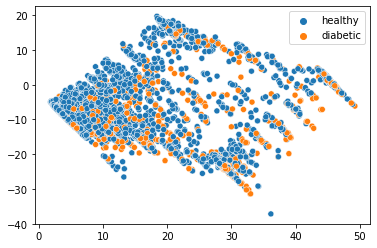

In [7]:
k = 2  # choose number of principal components to project upon
W = v[:, :k]

X_proj = X @ W
sns.scatterplot(x=X_proj[:,0], y=X_proj[:,1], hue=y)

We can see that diabetic patients tend to be more on the bottom right of that plot, but there still is a lot of unexplained variance.

I wonder if there are significant numerical errors in here. Covariance matrices are prone to it, since the condition number $k(X^tX) = k^2(X)$.  

Let's try with SVD.

True

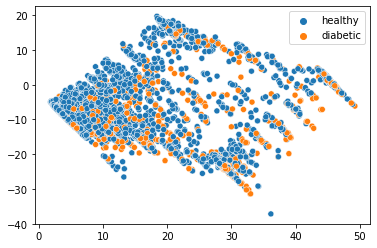

In [8]:
X_c = X - np.mean(X, axis=0)

k = 2

U, s, V_t = np.linalg.svd(X_c)
pc_index = (np.argsort(-s))[0:k]
W = V_t.T[:, pc_index]

X_proj_svd = X @ W
sns.scatterplot(x=X_proj[:,0], y=X_proj[:,1], hue=y)

np.allclose(X_proj_svd, X_proj)

Does not look like it changes much.

### Another way is to use a library like scikit-learn

In [9]:
from sklearn.decomposition import PCA

<AxesSubplot:>

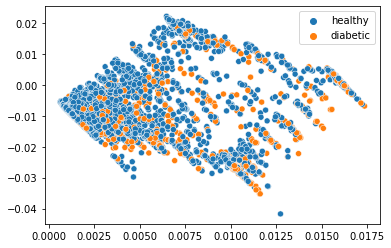

In [10]:
pca = PCA(n_components=2)

pc = pca.fit_transform(X.T)
X_proj /= np.linalg.norm(pc, axis=0)

sns.scatterplot(x=X_proj[:,0], y=X_proj[:,1], hue=y)